In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
import statistics
import seaborn as sns

## Load Emergent Properties and Node DataFrames for all Countries

In [2]:
allSpecies = pd.read_csv("./DataFiles/Dataframes/allCohorts_allSpecies.csv").set_index("SampleName")
americanSpecies = allSpecies[allSpecies['Cohort']=='American'].copy()
indianSpecies = allSpecies[allSpecies['Cohort']=='Indian'].copy()
europeanSpecies = allSpecies[allSpecies['Cohort']=='European'].copy()
japaneseSpecies = allSpecies[allSpecies['Cohort']=='Japanese'].copy()
allSpecies.shape

(606, 2079)

In [3]:
emergentDF = pd.read_csv("./DataFiles/GGM/Comparisons/AllComp_NetworkStruct.csv").set_index("Network")
eDF = emergentDF.copy()
eDF

,Nodes,Edges,Positive_Edges,Negative_Edges,Nodes_in_Largest_Component,Single_Nodes,Density,Average_Degree,Modularity,Connectedness,ASPL,Genera_Assortativity,Degree_Assortativity,Transitivity
Network,,,,,,,,,,,,,,
American,202,338,330,8,71,105,0.016649,3.346535,0.474739,False,1.539250,0.144392,0.337704,0.487374
Indian,202,273,264,9,82,98,0.013448,2.702970,0.666851,False,1.874499,0.163392,0.329600,0.452241
European,202,386,370,16,134,53,0.019014,3.821782,0.680941,False,1.369122,0.196079,0.157558,0.353107
Japanese,202,274,264,10,87,85,0.013497,2.712871,0.755207,False,1.444254,0.242277,0.307897,0.470558


In [4]:
tempDF1 = eDF[['Nodes','Edges','Positive_Edges','Negative_Edges','Density','Average_Degree','Modularity','ASPL','Transitivity','Genera_Assortativity','Degree_Assortativity']].copy()
tempDF1['P:N Ratio'] = 1
for i in tempDF1.index:
    tempDF1.at[i,'P:N Ratio'] = tempDF1.at[i,'Positive_Edges']/tempDF1.at[i,'Negative_Edges']
tempDF2 = tempDF1[['Nodes','Edges','Density','ASPL','Transitivity','Modularity','Degree_Assortativity','Genera_Assortativity']].copy()
tempDF3 = tempDF2.rename(columns={'Average_Degree':'Average Degree','Genera_Assortativity':'Genera Assortativity','Degree_Assortativity':'Degree Assortativity'}).copy()
tempDF3

,Nodes,Edges,Density,ASPL,Transitivity,Modularity,Degree Assortativity,Genera Assortativity
Network,,,,,,,,
American,202,338,0.016649,1.539250,0.487374,0.474739,0.337704,0.144392
Indian,202,273,0.013448,1.874499,0.452241,0.666851,0.329600,0.163392
European,202,386,0.019014,1.369122,0.353107,0.680941,0.157558,0.196079
Japanese,202,274,0.013497,1.444254,0.470558,0.755207,0.307897,0.242277


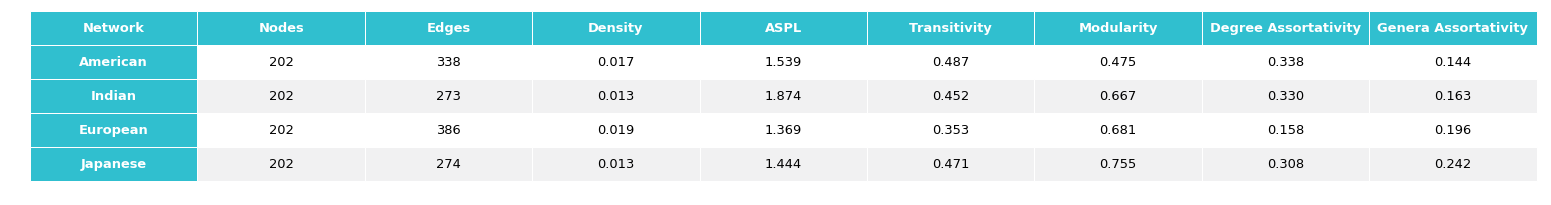

In [5]:
import six
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=13,
                     header_color='#30bfcf', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0, 
                     ax=None, **kwargs):
    
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    tab_2 = []
    for i in data.values:
        numm = 0
        tempList = []
        for j in i:
            if numm < 3:
                tempList.append(j)
            else:
                tempList.append('%.3f' % j)
            numm+=1
        tab_2.append(tempList)
        
    mpl_table = ax.table(cellText=tab_2, bbox=bbox, colLabels=data.columns, cellLoc='center', **kwargs)
    
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w', )
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
            
    return ax

fig = render_mpl_table(tempDF3.reset_index(), header_columns=1, col_width=3.0)
plt.show()

In [6]:
# Load Random Graph and Watts-Strogatz graphs for comparisons
Rdf_american = pd.read_csv("./DataFiles/GGM/Comparisons/Random/Rdf_american.csv")
Rdf_indian = pd.read_csv("./DataFiles/GGM/Comparisons/Random/Rdf_indian.csv")
Rdf_european = pd.read_csv("./DataFiles/GGM/Comparisons/Random/Rdf_european.csv")
Rdf_japanese = pd.read_csv("./DataFiles/GGM/Comparisons/Random/Rdf_japanese.csv")

Rdf_american.drop(columns=['Unnamed: 0'], inplace=True)
Rdf_indian.drop(columns=['Unnamed: 0'], inplace=True)
Rdf_european.drop(columns=['Unnamed: 0'], inplace=True)
Rdf_japanese.drop(columns=['Unnamed: 0'], inplace=True)

## Compute Dataframes and pvalues

In [7]:
def MonteCarloSimulationPvalues(model1, globaldf, networkName):
    
    ModeDict = ["Erdos-Renyi"]
    
    dfList2 = {"Model":[], "ASPL":[], "Genera_Assortativity":[], "Degree_Assortativity":[], "Transitivity":[],"Modularity":[]}
    keyss = list(dfList2.keys())
    keyss.pop(0)
    dfList3 = dfList2.copy()
    
    for model in ModeDict:
        
        if model == 'Erdos-Renyi':
            modelCompDF = model1.copy()
            
        dfList2["Model"].append(model)
        dfList3["Model"].append(model)

        
        for key in keyss:
            
            #Test to see if the value is greater or smaller than the models mean:
            
            if globaldf.at[networkName, key] > modelCompDF[key].mean():
                #Count how many times the real network was less then the model values
                myCountLarge = 0
                for row in modelCompDF.index:
                    if modelCompDF.at[row, key] >= globaldf.at[networkName, key]:
                        myCountLarge += 1
                
                pvalue = (myCountLarge+1)/(1001)
                
                #print("Large")
                #print(model)
                #print(key)
                #print(myCountLarge)
                #print(pvalue)
                #print("\n")
                
                if pvalue < (0.05):
                    dfList2[key].append("Reject: "+str(pvalue))
                    dfList3[key].append("Our Network: "+str(globaldf.at[networkName, key])+"> Model Mean: "+str(modelCompDF[key].mean()))
                else:
                    dfList2[key].append('Cannot Reject: '+str(pvalue))
                    dfList3[key].append("Our Network: "+str(globaldf.at[networkName, key])+"> Model Mean: "+str(modelCompDF[key].mean()))

                #########################################################################

            elif globaldf.at[networkName, key] < modelCompDF[key].mean():
                
                myCountSmall = 0
                for row in modelCompDF.index:
                    if modelCompDF.at[row, key] <= globaldf.at[networkName, key]:
                        myCountSmall +=1
                
                pvalue = (myCountSmall+1)/(1001)
                
                #print("SMALL")
                #print(model)
                #print(key)
                #print(myCountSmall)
                #print(pvalue)
                #print("\n")
                
                if pvalue < (0.05):
                    dfList2[key].append("Reject: "+str(pvalue))
                    dfList3[key].append("Our Network: "+str(globaldf.at[networkName, key])+"<  Mean: "+str(modelCompDF[key].mean()))

                else:
                    dfList2[key].append('Cannot Reject: '+str(pvalue))
                    dfList3[key].append("Our Network: "+str(globaldf.at[networkName, key])+"< Mean: "+str(modelCompDF[key].mean()))
                ########################################################################

            else:
                continue
                
                    
    df = pd.DataFrame(data=dfList2).set_index("Model")
    df2 = pd.DataFrame(data=dfList3).set_index("Model")

    return df, df2

In [8]:
#American Network Comparison
american_ModelComp, american2 = MonteCarloSimulationPvalues(Rdf_american,eDF, "American")
american_ModelComp['Cohort'] = 'American'
american_ModelComp

,ASPL,Genera_Assortativity,Degree_Assortativity,Transitivity,Modularity,Cohort
Model,,,,,,
Erdos-Renyi,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.001998001998001998,American
Erdos-Renyi,Our Network: 1.5392503167151057< Mean: 3.7410...,Our Network: 0.1443924104523122> Model Mean: -...,Our Network: 0.3377044006080874> Model Mean: -...,Our Network: 0.4873743016759777> Model Mean: 0...,Our Network: 0.4747385966295004> Model Mean: 0...,American


In [9]:
#Indian Network Comparison
indian_ModelComp, indian2 = MonteCarloSimulationPvalues(Rdf_indian,eDF, "Indian")
indian_ModelComp['Cohort'] = 'Indian'
indian_ModelComp

,ASPL,Genera_Assortativity,Degree_Assortativity,Transitivity,Modularity,Cohort
Model,,,,,,
Erdos-Renyi,Reject: 0.03796203796203796,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Indian
Erdos-Renyi,Our Network: 1.8744988600679657< Mean: 3.2242...,Our Network: 0.16339214113873296> Model Mean: ...,Our Network: 0.3296003666018433> Model Mean: -...,Our Network: 0.4522408329560888> Model Mean: 0...,Our Network: 0.6668514826424172> Model Mean: 0...,Indian


In [10]:
#European Network Comparison
european_ModelComp, european2 = MonteCarloSimulationPvalues(Rdf_european,eDF, "European")
european_ModelComp['Cohort'] = 'European'
european_ModelComp

,ASPL,Genera_Assortativity,Degree_Assortativity,Transitivity,Modularity,Cohort
Model,,,,,,
Erdos-Renyi,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.001998001998001998,Reject: 0.000999000999000999,Reject: 0.000999000999000999,European
Erdos-Renyi,Our Network: 1.3691224329480418< Mean: 3.7936...,Our Network: 0.1960791282528806> Model Mean: -...,Our Network: 0.15755776151606604> Model Mean: ...,Our Network: 0.3531073446327684> Model Mean: 0...,Our Network: 0.6809412239002172> Model Mean: 0...,European


In [11]:
#Japanese Network Comparison
japanese_ModelComp, american2 = MonteCarloSimulationPvalues(Rdf_japanese,eDF, "Japanese")
japanese_ModelComp['Cohort'] = 'Japanese'
japanese_ModelComp

,ASPL,Genera_Assortativity,Degree_Assortativity,Transitivity,Modularity,Cohort
Model,,,,,,
Erdos-Renyi,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Japanese
Erdos-Renyi,Our Network: 1.44425408860052< Mean: 3.240594...,Our Network: 0.2422774821732364> Model Mean: -...,Our Network: 0.3078968359478864> Model Mean: -...,Our Network: 0.4705583756345178> Model Mean: 0...,Our Network: 0.7552073956100699> Model Mean: 0...,Japanese


## Concat Results

In [12]:
aR = american_ModelComp[american_ModelComp.index=='Erdos-Renyi'].reset_index().drop(columns='Model').copy()
iR = indian_ModelComp[indian_ModelComp.index=='Erdos-Renyi'].reset_index().drop(columns='Model').copy()
eR = european_ModelComp[european_ModelComp.index=='Erdos-Renyi'].reset_index().drop(columns='Model').copy()
jR = japanese_ModelComp[japanese_ModelComp.index=='Erdos-Renyi'].reset_index().drop(columns='Model').copy()

In [13]:
compDFR = pd.concat([aR,iR,eR,jR])
compDFR.set_index("Cohort", inplace=True)

In [14]:
customAnnoDF = compDFR.copy()
customAnnoDF

,ASPL,Genera_Assortativity,Degree_Assortativity,Transitivity,Modularity
Cohort,,,,,
American,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.001998001998001998
American,Our Network: 1.5392503167151057< Mean: 3.7410...,Our Network: 0.1443924104523122> Model Mean: -...,Our Network: 0.3377044006080874> Model Mean: -...,Our Network: 0.4873743016759777> Model Mean: 0...,Our Network: 0.4747385966295004> Model Mean: 0...
Indian,Reject: 0.03796203796203796,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.000999000999000999
Indian,Our Network: 1.8744988600679657< Mean: 3.2242...,Our Network: 0.16339214113873296> Model Mean: ...,Our Network: 0.3296003666018433> Model Mean: -...,Our Network: 0.4522408329560888> Model Mean: 0...,Our Network: 0.6668514826424172> Model Mean: 0...
European,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.001998001998001998,Reject: 0.000999000999000999,Reject: 0.000999000999000999
European,Our Network: 1.3691224329480418< Mean: 3.7936...,Our Network: 0.1960791282528806> Model Mean: -...,Our Network: 0.15755776151606604> Model Mean: ...,Our Network: 0.3531073446327684> Model Mean: 0...,Our Network: 0.6809412239002172> Model Mean: 0...
Japanese,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Reject: 0.000999000999000999
Japanese,Our Network: 1.44425408860052< Mean: 3.240594...,Our Network: 0.2422774821732364> Model Mean: -...,Our Network: 0.3078968359478864> Model Mean: -...,Our Network: 0.4705583756345178> Model Mean: 0...,Our Network: 0.7552073956100699> Model Mean: 0...
